**Plan of the work:**

1)take model

2)take default CIFAR100 dataset

3)for fixed n_epochs measure acc after adv training

4)construct dataset from CIFAR100 with following changes:

*   for easy classes - decrease at half their number in dataset 

5)for fixed n_epochs measure acc after adv training

6)compare results from 3 and 5.





In [1]:
import random
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import os
import json 
from pathlib import Path
import pickle
from torchvision import datasets, transforms
from tqdm import tqdm
from copy import deepcopy
from collections import OrderedDict
import matplotlib.pyplot as plt

def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)

    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

In [2]:
set_seed(42)

#Model

In [3]:
!pip install efficientnet_pytorch
from efficientnet_pytorch import EfficientNet
model = EfficientNet.from_pretrained('efficientnet-b3', num_classes=200)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
# Move model to designated device (Use GPU when on Colab)
model = model.to(device)

/bin/bash: /opt/conda/lib/libtinfo.so.6: no version information available (required by /bin/bash)
  Preparing metadata (setup.py) ... done
  Created wheel for efficientnet_pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16446 sha256=36ab657c27abe1dee1173af4218e649760631e43feec76340e5cc7d87914d420
  Stored in directory: /root/.cache/pip/wheels/0e/cc/b2/49e74588263573ff778da58cc99b9c6349b496636a7e165be6
Successfully built efficientnet_pytorch


Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b3-5fb5a3c3.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b3-5fb5a3c3.pth


  0%|          | 0.00/47.1M [00:00<?, ?B/s]

Loaded pretrained weights for efficientnet-b3


# Dataset

In [6]:
# your api key
api_key = {"username":"spacehitchhiker","key":"c698b877d42f3f853d0a599e6263d8a8"}

# uses pathlib Path
kaggle_path = Path('/root/.kaggle')
os.makedirs(kaggle_path, exist_ok=True)

# opens file and dumps python dict to json object 
with open (kaggle_path/'kaggle.json', 'w') as handl:
    json.dump(api_key,handl)

os.chmod(kaggle_path/'kaggle.json', 600)  

!kaggle datasets download -d akash2sharma/tiny-imagenet

!unzip -qq tiny-imagenet.zip

/bin/bash: /opt/conda/lib/libtinfo.so.6: no version information available (required by /bin/bash)
 97%|███████████████████████████████████████▊ | 461M/474M [00:02<00:00, 219MB/s]
100%|█████████████████████████████████████████| 474M/474M [00:02<00:00, 185MB/s]
/bin/bash: /opt/conda/lib/libtinfo.so.6: no version information available (required by /bin/bash)


In [4]:
def load_dataset(data_path):
    # Load all the images
    data_mean = (0.5071, 0.4865, 0.4409)
    data_std = (0.2673, 0.2564, 0.2762)
    transformation = transforms.Compose([
        # transforms.RandomHorizontalFlip(0.5),
        # transforms.RandomVerticalFlip(0.3),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.25, .25, 0.25])
    ])

    full_dataset = datasets.ImageFolder(
        root=data_path,
        transform=transformation
    )
    train_size = int(0.75 * len(full_dataset))
    test_size = len(full_dataset) - train_size
    # use torch.utils.data.random_split for training/test split
    train_dataset, test_dataset = torch.utils.data.random_split(full_dataset, [train_size, test_size])
    # define a loader for the training data we can iterate through in 50-image batches
    train_loader = torch.utils.data.DataLoader(
        train_dataset,
        batch_size=32,
        num_workers=0,
        shuffle=True
    )
    test_loader = torch.utils.data.DataLoader(
        test_dataset,
        batch_size=32,
        num_workers=0,
        shuffle=False
    )

    return train_loader, test_loader

In [7]:
train_folder = '/kaggle/working/tiny-imagenet-200/train'
# Get the iterative dataloaders for test and training data
train_loader, test_loader = load_dataset(train_folder)

In [8]:
print(len(train_loader)*32,len(test_loader)*32)

75008 25024


#Adv training on default dataset

In [9]:
weight_decay = 5e-4
epsilon = 8
batch_size = 32
alpha = 2
loss_weight = 0.3
fgsm_step = 1
delta_init = 'random'
model.train()

optimizer = torch.optim.Adam(model.parameters(),lr=3e-4,weight_decay=weight_decay)
scaler = torch.cuda.amp.GradScaler()
criterion = nn.CrossEntropyLoss()

data_mean = (0.5071, 0.4865, 0.4409)
data_std = (0.2673, 0.2564, 0.2762)

mu = torch.tensor(data_mean).view(3, 1, 1).to(device)
std = torch.tensor(data_std).view(3, 1, 1).to(device)
upper_limit = ((1 - mu) / std)
lower_limit = ((0 - mu) / std)
epsilon = (epsilon / 255.) / std
alpha = (alpha / 255.) / std

if delta_init == 'previous':
    delta = torch.zeros(batch_size, 3, 32, 32).to(device)

prev_robust_acc = 0.

In [10]:
def clamp(X, lower_limit, upper_limit):
    return torch.max(torch.min(X, upper_limit), lower_limit)

In [25]:
NUM_CLASSES = 200

def attack_pgd(model, X, y, epsilon, alpha, attack_iters, restarts, lower_limit, upper_limit, args=None):

    max_loss = torch.zeros(y.shape[0]).to(device)
    max_delta = torch.zeros_like(X).to(device)
    scaler = torch.cuda.amp.GradScaler()

    for _ in range(restarts):
        delta = torch.zeros_like(X).to(device)
        for i in range(len(epsilon)):
            delta[:, i, :, :].uniform_(-epsilon[i][0][0].item(), epsilon[i][0][0].item())
        delta.data = clamp(delta, lower_limit - X, upper_limit - X)
        delta.requires_grad = True

        for _ in range(attack_iters):
            with torch.cuda.amp.autocast():
                output = model(X + delta)
                index = torch.where(output.max(1)[1] == y)[0]
                if len(index) == 0:
                    break
                loss = F.cross_entropy(output, y)

            scaler.scale(loss).backward()
            grad = delta.grad.detach()

            d = delta[index, :, :, :]
            g = grad[index, :, :, :]
            d = clamp(d + alpha * torch.sign(g), -epsilon, epsilon)
            d = clamp(d, lower_limit - X[index, :, :, :], upper_limit - X[index, :, :, :])

            delta.data[index, :, :, :] = d
            delta.grad.zero_()

        all_loss = F.cross_entropy(model(X + delta), y, reduction='none').detach()
        max_delta[all_loss >= max_loss] = delta.detach()[all_loss >= max_loss]
        max_loss = torch.max(max_loss, all_loss)

    return max_delta


def evaluate_pgd(test_loader, model, attack_iters, restarts, epsilon, alpha, lower_limit, upper_limit, args=None):

    examples_per_class = {i : 0 for i in range(NUM_CLASSES)}
    correct_per_class = {i : 0 for i in range(NUM_CLASSES)}

    pgd_loss, pgd_acc = 0, 0
    n = 0
    model.eval()
    for i, (X, y) in tqdm(enumerate(test_loader)):
        X, y = X.to(device), y.to(device)
        pgd_delta = attack_pgd(model, X, y, epsilon, alpha, attack_iters, restarts, lower_limit, upper_limit, args=args)
        with torch.no_grad():
            output = model(X + pgd_delta)
            preds = output.max(1)[1]
            for i in range(NUM_CLASSES):
                examples_per_class[i] += len(y[y==i])
                correct_per_class[i] += (preds[y==i] == i).sum().item()
            loss = F.cross_entropy(output, y)
            pgd_loss += loss.item() * y.size(0)
            pgd_acc += (output.max(1)[1] == y).sum().item()
            n += y.size(0)
        acc_per_class = {}
    for i in range(NUM_CLASSES):
        acc_per_class[i] = correct_per_class[i] / examples_per_class[i]
    return pgd_loss/n, pgd_acc/n,acc_per_class


def evaluate_standard(test_loader, model, args=None):
    
    examples_per_class = {i : 0 for i in range(NUM_CLASSES)}
    correct_per_class = {i : 0 for i in range(NUM_CLASSES)}
    
    test_loss, test_acc = 0, 0
    n = 0
    model.eval()
    with torch.no_grad():
        for i, (X, y) in tqdm(enumerate(test_loader), total=len(test_loader)):
            X, y = X.to(device), y.to(device)
            output = model(X)
            preds = output.max(1)[1]
            for i in range(NUM_CLASSES):
                examples_per_class[i] += len(y[y==i])
                correct_per_class[i] += (preds[y==i] == i).sum().item()
            loss = F.cross_entropy(output, y)
            test_loss += loss.item() * y.size(0)
            test_acc += (output.max(1)[1] == y).sum().item()
            n += y.size(0)
    acc_per_class = {}
    for i in range(NUM_CLASSES):
        acc_per_class[i] = correct_per_class[i] / examples_per_class[i]
    return test_loss/n, test_acc/n,acc_per_class


In [11]:
optimizer = torch.optim.Adam(model.parameters(),lr=3e-4,weight_decay=weight_decay)

epochs = 10
loop = tqdm(range(epochs))
for epoch in loop:
    train_loss,train_acc,train_n = 0,0,0
    # if epoch > 12:
    #   optimizer.param_groups[0]['lr'] = 1e-4
    model.train()
    for i, (X, y) in enumerate(train_loader):
        optimizer.zero_grad()
        X, y = X.to(device), y.to(device)
        if delta_init != 'previous':
            delta = torch.zeros_like(X).to(device)
        if delta_init == 'random':
            for j in range(len(epsilon)):
                delta[:, j, :, :].uniform_(-epsilon[j][0][0].item(), epsilon[j][0][0].item())
            delta.data = clamp(delta, lower_limit - X, upper_limit - X)
        if fgsm_step == 1:
            delta.requires_grad = True
            for _ in range(1):
                output = model(X + delta[:X.size(0)])
                loss = F.cross_entropy(output, y)
                scaler.scale(loss).backward()
                grad = delta.grad.detach()
                scaler.step(optimizer)
                scaler.update()
                delta.data = clamp(delta + alpha * torch.sign(grad), -epsilon, epsilon)
                delta.data[:X.size(0)] = clamp(delta[:X.size(0)], lower_limit - X, upper_limit - X)
            delta = delta.detach()
            output = model(X + delta[:X.size(0)])
            loss = (1 - loss_weight) * criterion(output, y) + loss_weight * criterion(model(X), y)
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            
        train_loss += loss.item() * y.size(0)
        train_acc += (output.max(1)[1] == y).sum().item()
        train_n += y.size(0)
      
    model.eval()
    pgd_loss, pgd_acc, acc_cl_pgd_at = evaluate_pgd(test_loader, model, 1, 5, epsilon, alpha, 
                                  lower_limit, upper_limit)
    
    if pgd_acc >= 0.4:
      best_state_dict = model.state_dict()
      torch.save(best_state_dict,'model_default_good.pth')
      
    loop.set_description(f'train acc: {round(train_acc / train_n,3)} test acc: {pgd_acc}')

train acc: 0.302 test acc: 0.25096:  50%|█████     | 5/10 [1:55:06<1:55:06, 1381.35s/it]


KeyboardInterrupt: ignored

In [12]:
best_state_dict_at = model.state_dict()

torch.save(best_state_dict_at,'model_default_at25.pth')

In [13]:
# Evaluation
model_at = EfficientNet.from_pretrained('efficientnet-b3', num_classes=200).to(device)
#model_at.load_state_dict(best_state_dict_at)
model_at.load_state_dict(torch.load('model_default_at25.pth'))
model_at.float()
model_at.eval()


pgd_loss, pgd_acc, acc_cl_pgd_at1 = evaluate_pgd(test_loader, model_at, 1, 5, epsilon, alpha, 
                                  lower_limit, upper_limit)
print(pgd_acc)
test_loss, test_acc, acc_cl_standart_at1 = evaluate_standard(test_loader, model_at)
print(test_acc)

Loaded pretrained weights for efficientnet-b3

0.25168


100%|██████████| 782/782 [00:59<00:00, 13.21it/s]

0.43716


#Accuracy and PpC

After 7 epochs - 34%

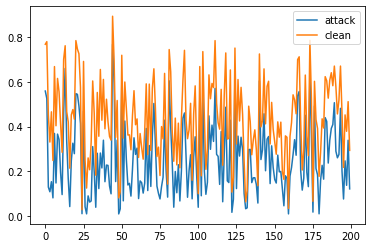

In [16]:
for_plot1 = list(acc_cl_pgd_at1.values())
for_plot2 = list(acc_cl_standart_at1.values())

plt.plot(range(200),for_plot1,label='attack')
plt.plot(range(200),for_plot2,label='clean')
plt.legend()

# Construct modified dataset

In [12]:
hard_classes = [24,42,49,65,94,99,131,159,172, 175, 197]
easy_classes = [0,1,14,44,45,78,103,115,143,145, 165, 166,176, 183, 191]

In [13]:
# Load all the images
data_mean = (0.5071, 0.4865, 0.4409)
data_std = (0.2673, 0.2564, 0.2762)

data_path = '/kaggle/working/tiny-imagenet-200/train'

transformation = transforms.Compose([
    # transforms.RandomHorizontalFlip(0.5),
    # transforms.RandomVerticalFlip(0.3),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.25, .25, 0.25])
])

full_dataset = datasets.ImageFolder(
    root=data_path,
    transform=transformation
)
train_size = int(0.75 * len(full_dataset))
test_size = len(full_dataset) - train_size
# use torch.utils.data.random_split for training/test split
train_dataset, test_dataset = torch.utils.data.random_split(full_dataset, [train_size, test_size])

In [14]:
targets = [item[1] for item in train_dataset]
data = [item[0] for item in train_dataset]
X_all_sampled, y_all_sampled = [], []

In [15]:
targets = np.array(targets)
data = np.array(data)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  


In [16]:
X_all_sampled, y_all_sampled = [], []
for c in range(200):
    X_all_c, y_all_c = data[targets==c],targets[targets==c]
    if c in easy_classes:
        num_samples = len(X_all_c)
        sampled_indices = torch.randperm(num_samples)[:(num_samples//3)]
        X_all_sampled.append(X_all_c[sampled_indices])
        y_all_sampled.append(y_all_c[sampled_indices]) 

    else:
        num_samples = len(X_all_c)
        sampled_indices = torch.randperm(num_samples)
        X_all_sampled.append(X_all_c[sampled_indices])
        y_all_sampled.append(y_all_c[sampled_indices]) 
    
X_all_sampled = np.concatenate(X_all_sampled, axis=0)
y_all_sampled = np.concatenate(y_all_sampled, axis=0)

X_all_sampled.shape

(71234,)

In [17]:
class ReducedDataset(torch.utils.data.Dataset):

    def __init__(self,X,y):
        self.X = X
        self.y = y
        self.transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.25, .25, 0.25])
        ])

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        sample = ((self.X)[idx],(self.y)[idx])
        return sample

In [18]:
train_dataset = ReducedDataset(X_all_sampled,y_all_sampled)
len(train_dataset)

71234

In [33]:
print(71234/75000,1200/1380)

0.9497866666666667 0.8695652173913043


In [19]:
# define a loader for the training data we can iterate through in 50-image batches
train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=32,
    num_workers=0,
    shuffle=True
)
test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=32,
    num_workers=0,
    shuffle=False
)

In [20]:
print(len(train_loader),len(test_loader))

2227 782


# Adv training on modified dataset

In [21]:
model = EfficientNet.from_pretrained('efficientnet-b3', num_classes=200).to(device)

optimizer = torch.optim.Adam(model.parameters(),lr=3e-4,weight_decay=weight_decay)

epochs = 5
loop = tqdm(range(epochs))
for epoch in loop:
    train_loss,train_acc,train_n = 0,0,0
    if epoch > 12:
      optimizer.param_groups[0]['lr'] = 1e-4

    model.train()
    for i, (X, y) in enumerate(train_loader):
        optimizer.zero_grad()
        X, y = X.to(device), y.to(device)
        if delta_init != 'previous':
            delta = torch.zeros_like(X).to(device)
        if delta_init == 'random':
            for j in range(len(epsilon)):
                delta[:, j, :, :].uniform_(-epsilon[j][0][0].item(), epsilon[j][0][0].item())
            delta.data = clamp(delta, lower_limit - X, upper_limit - X)
        if fgsm_step == 1:
            delta.requires_grad = True
            for _ in range(1):
                output = model(X + delta[:X.size(0)])
                loss = F.cross_entropy(output, y)
                scaler.scale(loss).backward()
                grad = delta.grad.detach()
                scaler.step(optimizer)
                scaler.update()
                delta.data = clamp(delta + alpha * torch.sign(grad), -epsilon, epsilon)
                delta.data[:X.size(0)] = clamp(delta[:X.size(0)], lower_limit - X, upper_limit - X)
            delta = delta.detach()
            output = model(X + delta[:X.size(0)])
            loss = (1 - loss_weight) * criterion(output, y) + loss_weight * criterion(model(X), y)
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            
        train_loss += loss.item() * y.size(0)
        train_acc += (output.max(1)[1] == y).sum().item()
        train_n += y.size(0)
      
    model.eval()
    pgd_loss, pgd_acc, acc_cl_pgd_at = evaluate_pgd(test_loader, model, 1, 5, epsilon, alpha, 
                                  lower_limit, upper_limit)
    
    if pgd_acc >= 0.4:
      best_state_dict = model.state_dict()
      torch.save(best_state_dict,'model_default_good.pth')   
      
    loop.set_description(f'train acc: {round(train_acc / train_n,3)} test acc: {pgd_acc}')

Loaded pretrained weights for efficientnet-b3


train acc: 0.291 test acc: 0.2454: 100%|██████████| 5/5 [1:39:57<00:00, 1199.48s/it]  


In [24]:
best_state_dict_at = model.state_dict()

torch.save(best_state_dict_at,'model_default_reduced25.pth')

In [26]:
model.eval()


pgd_loss, pgd_acc, acc_cl_pgd_at2 = evaluate_pgd(test_loader, model, 1, 5, epsilon, alpha, 
                                  lower_limit, upper_limit)
print(pgd_acc)
test_loss, test_acc, acc_cl_standart_at2 = evaluate_standard(test_loader, model)
print(test_acc)

782it [08:44,  1.49it/s]


0.24524


100%|██████████| 782/782 [01:04<00:00, 12.18it/s]

0.43308


Near the same overall accuracy(32% against 34%) with 5% data reduced.
Time per iteration reduced from 207.5s to 200.5s (~3%)

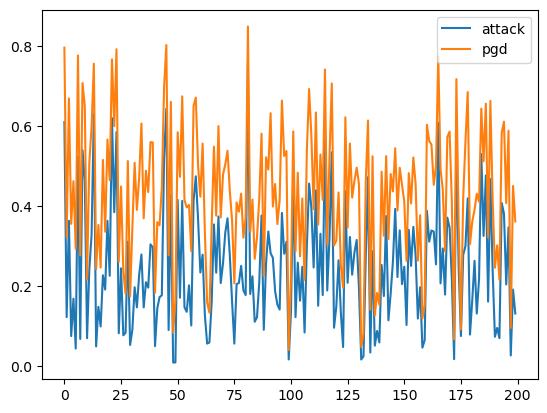

In [31]:
for_plot1 = list(acc_cl_pgd_at2.values())
plt.plot(range(200),for_plot1,label='attack')   

for_plot2 = list(acc_cl_standart_at2.values())
plt.plot(range(200),for_plot2,label='pgd')

plt.legend()